# Image Captioning

## Download DataSet from Kaggle

In [1]:
# The following code allows you to upload files to Google Colab from your local machine.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"callmevicki","key":"1f48b26fc8c5ecb586f9a82d8bed75b7"}'}

In [2]:
# Create a directory named '.kaggle' in the home directory to store Kaggle API credentials.
!mkdir ~/.kaggle

# Copy the Kaggle API credentials file 'kaggle.json' to the '.kaggle' directory in the home folder.
!cp kaggle.json ~/.kaggle/

In [3]:
# Download the Bangladeshi Crops Disease Classification dataset from Kaggle using the dataset ID.
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:52<00:00, 21.7MB/s]
100% 1.04G/1.04G [00:52<00:00, 21.1MB/s]


In [ ]:
!unzip /content/flickr8k.zip

## Import dependencies

In [9]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [6]:
# load vgg16 model
pre_trained_model = VGG16()
# restructure the model
pre_trained_model = Model(inputs=pre_trained_model.inputs, outputs=pre_trained_model.layers[-2].output)
# summarize
print(pre_trained_model.summary())

553467096/553467096 [==============================] - 24s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [7]:
print(os.listdir('Images')[0])

130211457_be3f6b335d.jpg


In [8]:
# extract features from image
features = {}
directory = 'Images'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = pre_trained_model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [10]:
# store features in pickle
pickle.dump(features, open('features.pkl', 'wb'))

In [11]:
# Load features from pickle
with open('features.pkl', 'rb') as f:
  features = pickle.load(f)

## Load Caption data

In [22]:
with open('captions.txt', 'r') as text:
  next(text)
  captions_doc = text.read()

In [23]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [24]:
len(mapping)

8091

## Preprocess Text data

In [25]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
        caption = captions[i]
        caption = caption.lower()
        caption = caption.replace('[^A-Za-z]', '')
        caption = caption.replace('\s+', ' ')
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
        captions[i] = caption

In [26]:
# before preprocess of text
mapping['2362481035_a7600875d0']

['A blonde boy in green is on a swing .',
 'A little girl with blond hair is smiling and sitting in a swing .',
 'A young child smiling while on a swing at a playground .',
 'The small child is leaning back in a child swing .',
 'Toddler boy smiling while in a swing']

In [27]:
# preprocess the text
clean(mapping)

In [28]:
# after preprocess of text
mapping['2362481035_a7600875d0']

['startseq blonde boy in green is on swing endseq',
 'startseq little girl with blond hair is smiling and sitting in swing endseq',
 'startseq young child smiling while on swing at playground endseq',
 'startseq the small child is leaning back in child swing endseq',
 'startseq toddler boy smiling while in swing endseq']

In [29]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [30]:
len(all_captions)

40455

In [31]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"vocab_size: {vocab_size}")

vocab_size: 8485


In [35]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [36]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [38]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

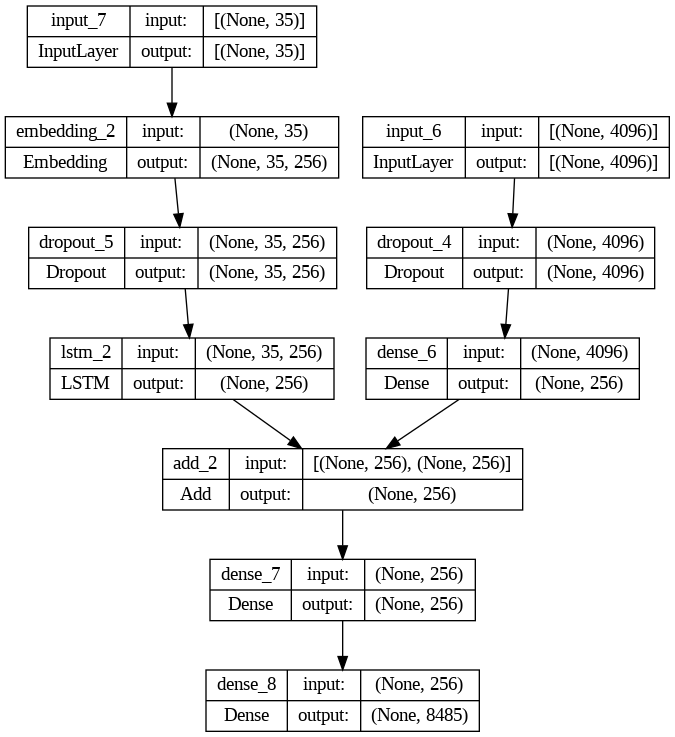

In [42]:
# Encoder Model
## Image Feature Layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
## Sequence Feature Layer
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# plot the model
plot_model(model, show_shapes=True)

In [43]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 65s 288ms/step - loss: 2.1980


In [44]:
# save the model
model.save('image_captioning_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Generate Captions for the Image

In [45]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [51]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    cut_text = ' '.join(in_text.split()[1:-1])
    return cut_text

In [47]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.531041
BLEU-2: 0.306495


## Visualize the Results

In [52]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join("Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq collage of one person climbing cliff endseq
startseq group of people are rock climbing on rock climbing wall endseq
startseq group of people climbing rock while one man belays endseq
startseq seven climbers are ascending rock face whilst another man stands holding the rope endseq
startseq several climbers in row are climbing the rock while the man in red watches and holds the line endseq
--------------------Predicted--------------------
collage of climbers are climbing up rock wall


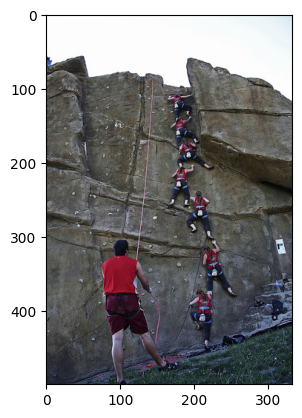

In [57]:
generate_caption("1016887272_03199f49c4.jpg")

---------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
--------------------Predicted--------------------
two constructions workers are sitting on the sidewalk


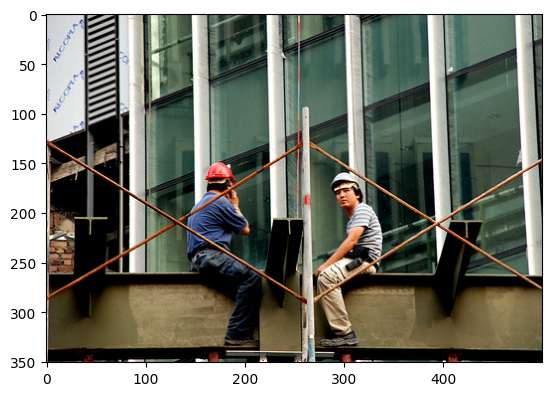

In [54]:
generate_caption("1055753357_4fa3d8d693.jpg")

## Test With Google Images

In [65]:
def google_image_testing(image_path):
    image = load_img(image_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    img_feature = pre_trained_model.predict(image, verbose=0)
    # predict the caption
    predicted = predict_caption(model, img_feature, tokenizer, max_length)
    plt.imshow(Image.open(image_path))
    print(f"Caption: {predicted}")

Caption: two dogs running in the grass


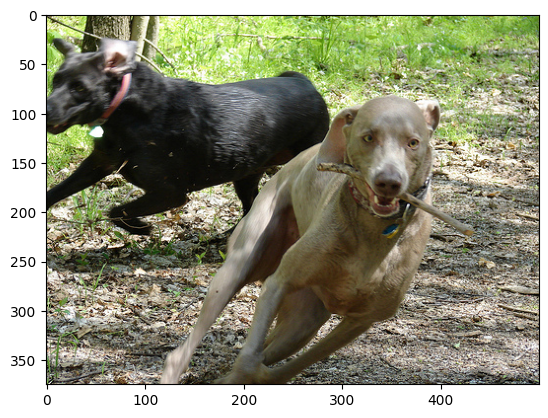

In [56]:
google_image_testing("OIP.jpg")

Caption: man and dog are playing in the water


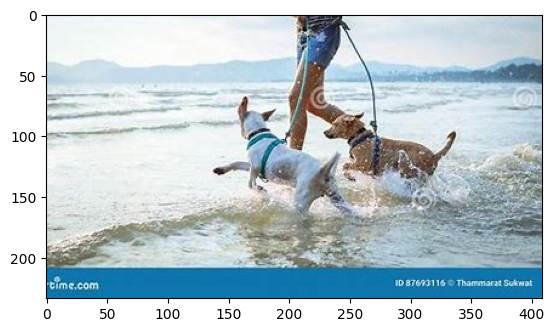

In [67]:
google_image_testing("OIP.jpg")

Caption: hiker stands on the edge of large rock


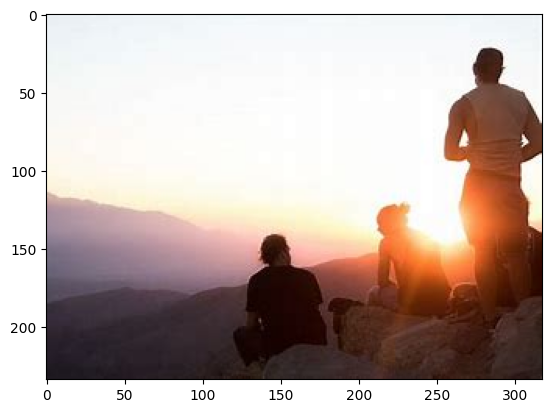

In [73]:
google_image_testing("OIP.jpg")

Caption: two boys in field


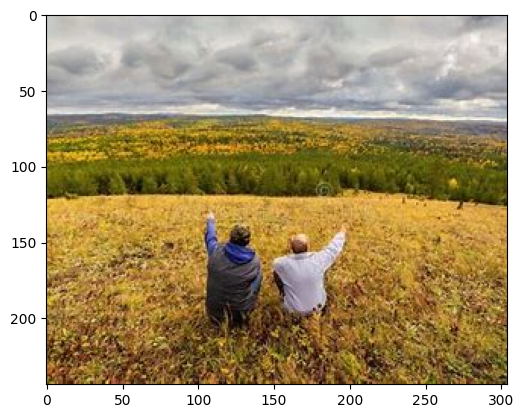

In [75]:
google_image_testing("OIP.jpg")

Caption: man in red shirt kicking soccer ball


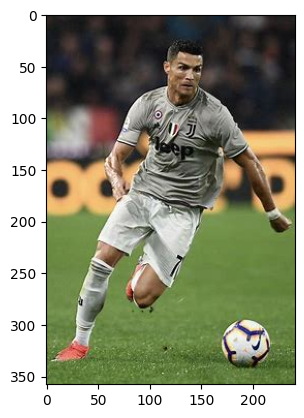

In [78]:
google_image_testing("OIP.jpg")

Caption: baseball player pitching baseball


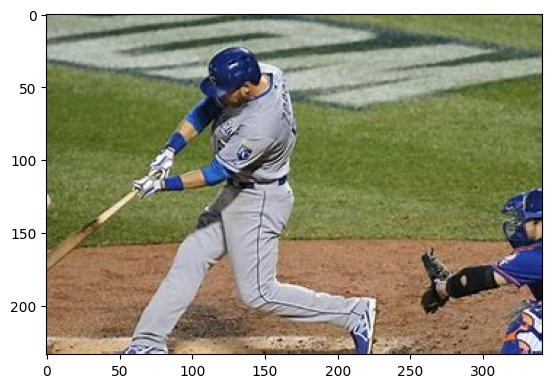

In [88]:
google_image_testing("OIP.jpg")